# 🚀 Space Launch Mission Success Analysis
##  Group Presentation 5

**Team Members:**  
- Reham Abuarqoub, 9062922
- Erica Holden, 5490685
- Yu-Chen Chou (Tracy), 9006160 



#  Term Project - Space Mission Dataset Extension
We use the Global Space Mission Launches dataset. This data provides historical records of launch events, locations, companies, rocket types, and success status. According to the dataset, we implement a simple linear regression to analyze the X independent variable and the y dependent variable, and explore the analysis of Homoscedasticity and R-Squared Measure.

## Step1: Load dataset

In [134]:
# Import library
import pandas as pd

# Load a CSV file into a DataFrame
df = pd.read_csv('./data/Space_Corrected.csv')

# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0.1,Unnamed: 0,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


## Step2: Clean dataset and check missing values

In [135]:
# Import library
from sklearn.preprocessing import LabelEncoder

# Define a class for cleaning the space mission dataset
class SpaceMissionCleaner:
    def __init__(self, df):
        self.df = df

    def clean(self):
        df = self.df.copy()
        df.columns = df.columns.str.strip()
        df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, errors='ignore')
        df['Datum'] = pd.to_datetime(df['Datum'], errors='coerce')
        df.dropna(inplace=True)
        df['Rocket'] = pd.to_numeric(df['Rocket'], errors='coerce')
        df = df[df['Rocket'] > 0]
        df['Success'] = df['Status Mission'].apply(lambda x: 1 if 'Success' in x else 0)
        df['Company Code'] = LabelEncoder().fit_transform(df['Company Name'])
        return df

# Create an instance of SpaceMissionCleaner and clean the DataFrame 
df_clean = SpaceMissionCleaner(df).clean()
df_clean.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,Success,Company Code
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,1,18
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,1,2
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,1,17
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,1,19
5,CASC,"LC-9, Taiyuan Satellite Launch Center, China",2020-07-25 03:13:00+00:00,"Long March 4B | Ziyuan-3 03, Apocalypse-10 & N...",StatusActive,64.68,Success,1,2


In [136]:
# Check for missing values
missing_values = df_clean.isnull().sum()
print("Missing values in each column:")
print(missing_values)
print("\n")

# Check the data types of each column
print("Data types of each column:")
print(df_clean.info())

Missing values in each column:
Company Name      0
Location          0
Datum             0
Detail            0
Status Rocket     0
Rocket            0
Status Mission    0
Success           0
Company Code      0
dtype: int64


Data types of each column:
<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 0 to 4020
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Company Name    943 non-null    object             
 1   Location        943 non-null    object             
 2   Datum           943 non-null    datetime64[ns, UTC]
 3   Detail          943 non-null    object             
 4   Status Rocket   943 non-null    object             
 5   Rocket          943 non-null    float64            
 6   Status Mission  943 non-null    object             
 7   Success         943 non-null    int64              
 8   Company Code    943 non-null    int64              
dtypes: datetime64[n

## Step 3: Implement a Simple Linear Regression, R-Squared Measure, and Homoscedasticity
Assume that there are three sets of independent variables X, and a dependent variable y to implement simple linear regression. Three sets of independent variables X and a dependent variable y, as shown below:

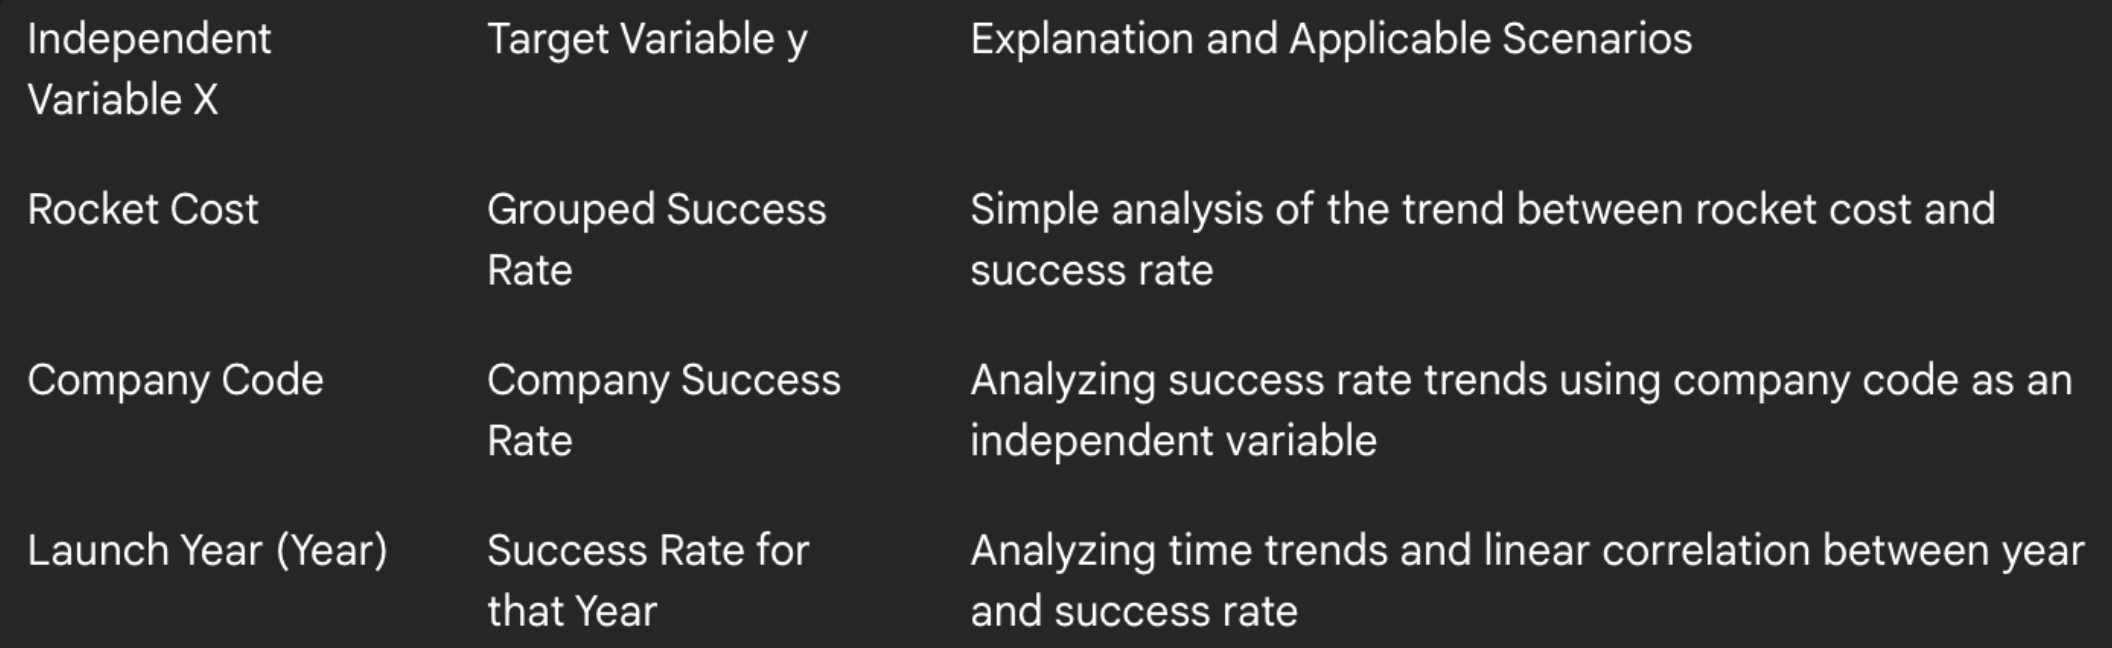


### Group 1: Company vs Space Missions Success

In [137]:
# Define a class for rocket cost and success analyzer
class RocketSuccessAnalyzer:
    def __init__(self, df, rocket_col='Rocket', success_col='Success'):
        self.df = df.copy()
        self.rocket_col = rocket_col
        self.success_col = success_col
        self.binned_data = None # Stores the DataFrame after binning
        self.success_rate_by_bin = None # Stores the success rate calculated per bin

    def bin_rocket_cost(self, bins=10, duplicates='drop'):
        self.df['Rocket_bin'] = pd.qcut(self.df[self.rocket_col], q=bins, duplicates=duplicates)
        return self.df

    def calc_success_rate_per_bin(self):
        success_rate_by_rocket = self.df.groupby('Rocket_bin', observed=True)[self.success_col].mean().reset_index()
        success_rate_by_rocket['Rocket_Median'] = success_rate_by_rocket['Rocket_bin'].apply(lambda x: x.mid)
        #self.binned_df = success_rate_by_rocket
        return success_rate_by_rocket

# Initialize the analysis object
analyzer = RocketSuccessAnalyzer(df_clean)

# Binning
analyzer.bin_rocket_cost(bins=10) # Rocket costs are divided into 10 ranges

# Calculate the success rate (including the median rocket cost)
success_rate_per_bin_df = analyzer.calc_success_rate_per_bin()

# Display the success rate per bin
print("Success Rate per Rocket Cost Bin:")
success_rate_per_bin_df

Success Rate per Rocket Cost Bin:


,Rocket_bin,Success,Rocket_Median
0,"(5.2989999999999995, 29.15]",0.875000,17.2245
1,"(29.15, 31.0]",0.978261,30.0750
2,"(31.0, 40.0]",0.920455,35.5000
3,"(40.0, 50.0]",0.899160,45.0000
4,"(50.0, 62.0]",0.951807,56.0000
5,"(62.0, 85.0]",0.929412,73.5000
6,"(85.0, 120.0]",0.989011,102.5000
7,"(120.0, 200.0]",0.977612,160.0000
8,"(200.0, 450.0]",0.979592,325.0000


In [138]:
# Import library
from sklearn.linear_model import LinearRegression

# Define a class for linear regression analysis
class ExecuteLRModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.model = None
        self.y_pred = None
        self.r_squared = None

    def lr_model(self):
        self.model = LinearRegression() # Create the linear regression model
        self.model.fit(self.X, self.y) # Fit the model
        return self.model
    
    def y_predict(self):
        if self.model is None:
            raise ValueError("Please run lr_model() first.")
        self.y_pred = self.model.predict(self.X) # Predict the y values
        return self.y_pred

    def print_intercept_and_slope(self):
        if self.model is None:
            raise ValueError("Please run lr_model() first.")
        print(f"Intercept: {self.model.intercept_:.6f}")
        print(f"Slope: {self.model.coef_[0]:.6f}")
    
    def print_r_squared(self):
        if self.model is None:
            raise ValueError("Please run lr_model() first.")
        self.r_squared = self.model.score(self.X, self.y)
        print(f"R-squared: {self.r_squared:.6f}")
        

# Define X independent variable and y dependent variable
X = success_rate_per_bin_df[['Rocket_Median']] # continuous numerical substitution
y = success_rate_per_bin_df['Success']

# Execute a Linear Regression model
lr_analysis = ExecuteLRModel(X, y)
model_object = lr_analysis.lr_model()

# Predict y values
y_pred = lr_analysis.y_predict()

# Display the model's intercept and coefficient
lr_analysis.print_intercept_and_slope()

# R-squared measurement
r_squared = lr_analysis.print_r_squared()

Intercept: 0.922700
Slope: 0.000232
R-squared: 0.307874


- Intercept is about 0.9227. Indicates that when the rocket cost approaches 0 (theoretically unlikely), the estimated mission success rate is about 92.27%. If the cost is extremely low, maybe this model's baseline success rate
- The slope is about 0.000232. Indicates that for every unit increase in rocket cost (assuming the same currency unit), the mission success rate increases by about 0.0232%. In this case, the slope is very small. Even with the cost increases, the success rate increases very slowly
- The R-squared is about 30.79%, but there are still about 69.21% of the variation that cannot be captured by this simple linear regression model. There may be other important factors that affect the success rate

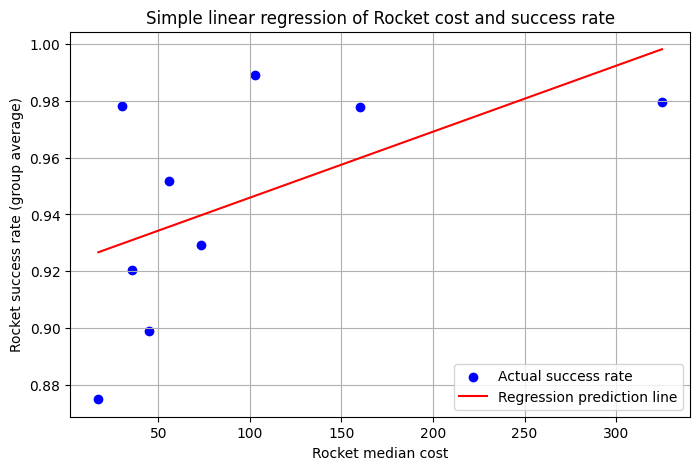

In [139]:
# Import function
import matplotlib.pyplot as plt

# Define a class for plotting linear regression results
class RegressionPlotter:
    def __init__(self, X, y, y_pred):
        self.X = X
        self.y = y
        self.y_pred = y_pred

    def plot_regression(self):
        plt.figure(figsize=(8,5))
        plt.scatter(self.X, self.y, color='blue', label='Actual success rate')
        plt.plot(self.X, self.y_pred, color='red', label='Regression prediction line')
        plt.xlabel('Rocket median cost')
        plt.ylabel('Rocket success rate (group average)')
        plt.title('Simple linear regression of Rocket cost and success rate')
        plt.legend()
        plt.grid()
        plt.show()

# Create an instance of RegressionPlotter and plot the regression
plotter = RegressionPlotter(X, y, y_pred)
plotter.plot_regression()

- The blue scatter points represent the "average success rate in the range" corresponding to the "median rocket cost range" after grouping
- The red straight line is the fitting line of the simple linear regression model, showing the trend of success rate changing with cost
- The scatter points show a slight upward trend, verifying that there is a positive relationship between cost and success rate, but the trend is mild and close to flat
- The success rate in the low-cost and medium-high cost range is about 0.9 or above, reflecting that the overall success rate is already quite high, and the impact of rocket cost on the success rate improvement is limited

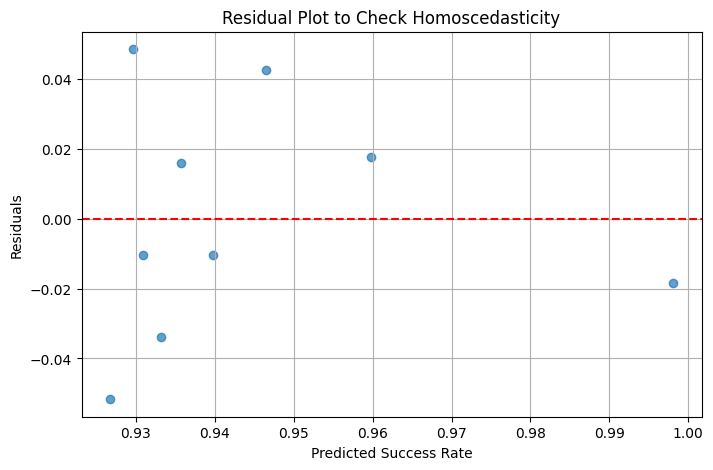

In [140]:
# Define a class for plotting residuals to check homoscedasticity
class ResidualPlotter:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.residuals = self.y_true - self.y_pred
    
    def plot_residuals(self):
        plt.figure(figsize=(8,5))
        plt.scatter(self.y_pred, self.residuals, alpha=0.7)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted Success Rate')
        plt.ylabel('Residuals')
        plt.title('Residual Plot to Check Homoscedasticity')
        plt.grid()
        plt.show()

# Create an instance of ResidualPlotter and plot the residuals
plotter = ResidualPlotter(y, y_pred)
plotter.plot_residuals()

- The number of data points is small, which makes it difficult and uncertain to judge the pattern
- The residual distribution is a positive sign, with no obvious "scalloped" or "funnel-shaped" pattern observed. The model is likely to meet the assumption of Heteroscedasticity

### Group 2: Company Code vs Company Space Missions Success Rate 

In [141]:
class CompanySuccessRate:
    def __init__(self, df, company_col='Company Code', success_col='Success'):
        self.df = df.copy()
        self.company_col = company_col
        self.success_col = success_col
        self.company_stats = None
        self.model = None
        self.y_pred = None

    def prepare_success_rate(self):
        stats = self.df.groupby(self.company_col)[self.success_col].mean().reset_index()
        stats.columns = [self.company_col, 'Success_Rate_Company']
        self.company_stats = stats
        return stats

# Initialize the CompanySuccessRate object and prepare success rate
csr = CompanySuccessRate(df_clean)

print("Company Success Rate DataFrame:")
csr.prepare_success_rate()

Company Success Rate DataFrame:


,Company Code,Success_Rate_Company
0,0,0.968750
1,1,0.857143
2,2,0.961783
3,3,0.000000
4,4,1.000000
5,5,0.923077
6,6,0.000000
7,7,1.000000
8,8,0.878788
9,9,1.000000


In [142]:
# Define X independent variable and y dependent variable
X2 = csr.company_stats[[csr.company_col]]
y2 = csr.company_stats['Success_Rate_Company']

# Execute a Linear Regression model
lr_analysis_2 = ExecuteLRModel(X2, y2)
model_object = lr_analysis_2.lr_model()

# Predict y values
y_pred_2 = lr_analysis_2.y_predict()

# Display the model's intercept and coefficient
lr_analysis_2.print_intercept_and_slope()

# R-squared measurement
r_squared_2 = lr_analysis_2.print_r_squared()

Intercept: 0.805614
Slope: 0.000893
R-squared: 0.000341


- The model slope is very small (0.00089), which means that the company code has almost no effect on the success rate
- R² = 0.0003, almost 0, which means that this model cannot effectively explain the variation of the success rate by "company code"

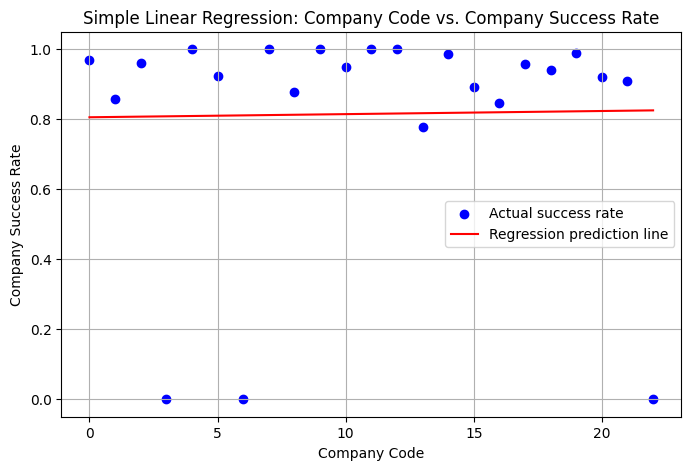

In [143]:
# Define a class for plotting linear regression results
class RegressionPlotter:
    def __init__(self, X, y, y_pred):
        self.X = X
        self.y = y
        self.y_pred = y_pred

    def plot_regression(self):
        plt.figure(figsize=(8,5))
        plt.scatter(self.X, self.y, color='blue', label='Actual success rate')
        plt.plot(self.X, self.y_pred, color='red', label='Regression prediction line')
        plt.xlabel('Company Code')
        plt.ylabel('Company Success Rate')
        plt.title('Simple Linear Regression: Company Code vs. Company Success Rate')
        plt.legend()
        plt.grid()
        plt.show()

# Create an instance of RegressionPlotter and plot the regression
plotter = RegressionPlotter(X2, y2, y_pred_2)
plotter.plot_regression()

- The success rate of most companies is above 0.8. Only three companies are 0
- The regression line is very flat, indicating that there is basically no linear correlation between the company code and the company's success rate

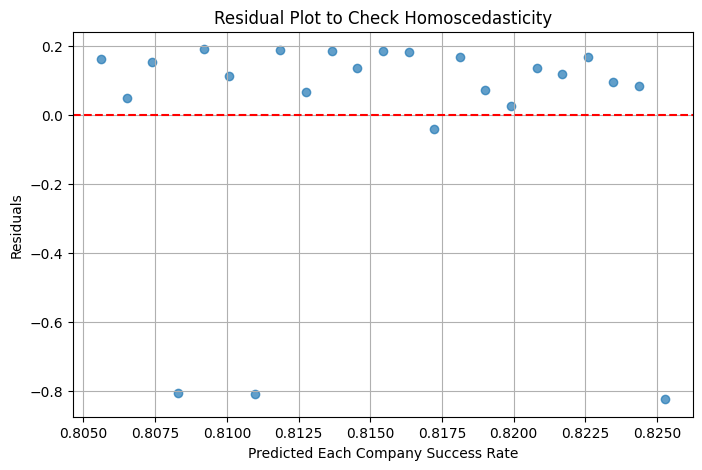

In [144]:
# Define a class for plotting residuals to check homoscedasticity
class ResidualPlotter:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.residuals = self.y_true - self.y_pred
    
    def plot_residuals(self):
        plt.figure(figsize=(8,5))
        plt.scatter(self.y_pred, self.residuals, alpha=0.7)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted Each Company Success Rate')
        plt.ylabel('Residuals')
        plt.title('Residual Plot to Check Homoscedasticity')
        plt.grid()
        plt.show()

# Create an instance of ResidualPlotter and plot the residuals
plotter = ResidualPlotter(y2, y_pred_2)
plotter.plot_residuals()

- This figure conforms to Homoscedasticity
    - The residuals show a randomly distributed and consistent range of variation in all prediction value intervals
    - The model is stable. There is no unusual clustering or divergence

### Group 3: Launch Year vs Space Missions Success Rate fro that Year

In [145]:
class YearlySuccessRate:
    def __init__(self, df, date_col='Datum', success_col='Success'):
        self.df = df.copy()
        self.date_col = date_col
        self.success_col = success_col
        self.yearly_stats = None
        self.model = None
        self.y_pred = None

    def prepare_yearly_success_rate(self):
        self.df['Year'] = pd.to_datetime(self.df[self.date_col]).dt.year
        stats = self.df.groupby('Year')[self.success_col].mean().reset_index()
        stats.columns = ['Year', 'Success_Rate_Year']
        self.yearly_stats = stats
        return stats

# Initialize the YearlySuccessRate object and prepare success rate
ysr = YearlySuccessRate(df_clean)

print("Yearly Success Rate DataFrame:")
ysr.prepare_yearly_success_rate()

Yearly Success Rate DataFrame:


,Year,Success_Rate_Year
0,1964,0.500000
1,1965,1.000000
2,1966,1.000000
3,1967,0.833333
4,1968,1.000000
5,1969,1.000000
6,1981,1.000000
7,1982,1.000000
8,1983,1.000000
9,1984,1.000000


In [146]:
# Define X independent variable and y dependent variable
X3 = ysr.yearly_stats[['Year']]
y3 = ysr.yearly_stats['Success_Rate_Year']

# Execute a Linear Regression model
lr_analysis_3 = ExecuteLRModel(X3, y3)
model_object = lr_analysis_3.lr_model()

# Predict y values
y_pred_3 = lr_analysis_3.y_predict()

# Display the model's intercept and coefficient
lr_analysis_3.print_intercept_and_slope()

# R-squared measurement
r_squared_3 = lr_analysis_3.print_r_squared()

Intercept: -1.028397
Slope: 0.000982
R-squared: 0.026025


- Intercept: It is negative, which means it has no practical significance. This may be because data from too old years will cause distortion
- Slope: Every year, the rocket success rate increases by an average of about 0.098%. This means that space launches are gradually improving, but the success rate is slow due to multiple factors
- R-squared: About 2.6% success rate. It means that although there is a trend between the year and the year success rate, it is not a linear dominant factor

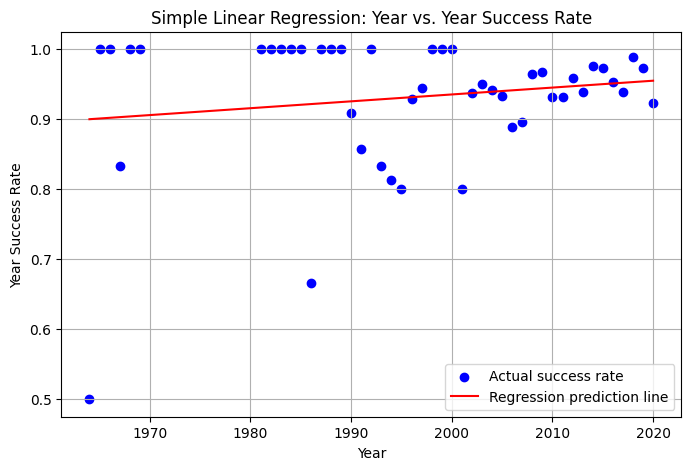

In [147]:
# Define a class for plotting linear regression results
class RegressionPlotter:
    def __init__(self, X, y, y_pred):
        self.X = X
        self.y = y
        self.y_pred = y_pred

    def plot_regression(self):
        plt.figure(figsize=(8,5))
        plt.scatter(self.X, self.y, color='blue', label='Actual success rate')
        plt.plot(self.X, self.y_pred, color='red', label='Regression prediction line')
        plt.xlabel('Year')
        plt.ylabel('Year Success Rate')
        plt.title('Simple Linear Regression: Year vs. Year Success Rate')
        plt.legend()
        plt.grid()
        plt.show()

# Create an instance of RegressionPlotter and plot the regression
plotter = RegressionPlotter(X3, y3, y_pred_3)
plotter.plot_regression()

- The regression line is almost horizontal, with no obvious trend. The success rate is close to 90%~100% throughout the year
- The model performance is stable, and most of the points are concentrated in the success rate range of 0.90~1.0
- The linear model shows that the year is not an effective predictor of success rate, but it is still valuable as a visualization of the history of technological development

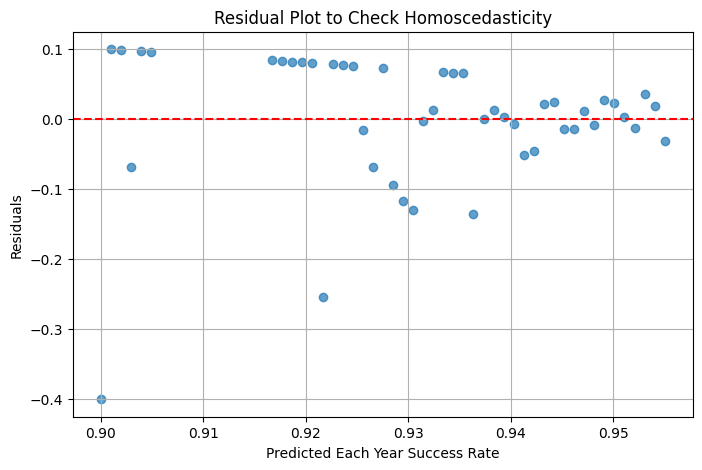

In [148]:
# Define a class for plotting residuals to check homoscedasticity
class ResidualPlotter:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.residuals = self.y_true - self.y_pred
    
    def plot_residuals(self):
        plt.figure(figsize=(8,5))
        plt.scatter(self.y_pred, self.residuals, alpha=0.7)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted Each Year Success Rate')
        plt.ylabel('Residuals')
        plt.title('Residual Plot to Check Homoscedasticity')
        plt.grid()
        plt.show()

# Create an instance of ResidualPlotter and plot the residuals
plotter = ResidualPlotter(y3, y_pred_3)
plotter.plot_residuals()

- The residual points are in the range of 0.94-0.96, and the dispersion is significantly reduced. No obvious funnel shape. Maybe it conforms to homoscedasticity
- Have potential outliers (negative residual) in 0.90 and 0.92. Maybe it can influence the fitting of the regression line

## Step 4: Conclusion
About the simple linear regression of three groups implemented:
- This model cannot fully reflect the strong linear positive correlation between the independent variable X and the dependent variable y
- R² indicates that the model has limited explanatory power and is not sufficient to fully explain the fluctuations in success rates
- Residual plots help confirm homoscedasticity, make the basic regression assumptions valid, and increase the credibility of the results
- It is recommended to try multiple linear regression combined with multiple independent variables to improve the model's predictive ability